# OOI Cabled Array Hack Week (CAHW): Simple netCDF plots

This notebook is designed to explore netCDF streamed datasets from the OOI Cabled Array, using Friedrich's initial template as a guide, we'll load some data, make some plots/changes and go from there. 

## Data Import: Stream Data from OOI

In [12]:
### Set up the python environment, copied from the tutorials

# basic python system stuff
import re
import os
import requests
import time
import datetime

# specialized scientific packages
import xarray as xr
import pandas as pd
import netCDF4 as nc

# plotting packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from IPython import display

In [13]:
import netrc

# Setup netrc per Friedrich's instructions, alternatively you can use simple token auth

## simple
# username ='<INSERT YOUR USERNAME HERE>'
#token = '<INSERT YOUR TOKEN HERE>'

## netrc approach. .netrc in home directory needs 0700 permissions
netrc = netrc.netrc()
remoteHostName = "ooinet.oceanobservatories.org"
info = netrc.authenticators(remoteHostName)
username = info[0]
token = info[2]

In [14]:
## parameters for the node and sensore we are working with
subsite = 'RS01SBPS'
node = 'SF01A'
sensor = '2A-CTDPFA102'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

## set time slice we are interested in to be the period of the eclipse
beginDT = '2017-08-20T00:00:00.000Z'
endDT = '2017-08-23T00:00:00.000Z'

In [15]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))

params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}

# note: there is a "session" approach here as well instead of the raw request that can help if the server gets 
# bogged down 
# TODO: get details from Fcheck_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

r = requests.get(data_request_url, params=params, auth=(username, token))
data = r.json()

NameError: name 'check_complete' is not defined

In [7]:
data['allURLs'][1]

NameError: name 'data' is not defined

In [35]:
data['allURLs'][0]

'https://opendap.oceanobservatories.org/thredds/catalog/ooi/cbps@uw.edu/20180223T070149-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html'

In [11]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

NameError: name 'data' is not defined

In [37]:
url = data['allURLs'][0]
# url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/friedrich.knuth@rutgers.edu/20180221T052204-RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]

In [38]:
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/cbps@uw.edu/20180223T070149-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/deployment0004_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20170820T000000.731864-20170822T235959.926493.nc']

In [39]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds

<xarray.Dataset>
Dimensions:                     (time: 259194)
Coordinates:
    obs                         (time) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
  * time                        (time) datetime64[ns] 2017-08-20T00:00:00.731864576 ...
    lat                         (time) float64 dask.array<shape=(259194,), chunksize=(259194,)>
    lon                         (time) float64 dask.array<shape=(259194,), chunksize=(259194,)>
Data variables:
    deployment                  (time) int32 dask.array<shape=(259194,), chunksize=(259194,)>
    id                          (time) |S64 dask.array<shape=(259194,), chunksize=(259194,)>
    conductivity                (time) float64 dask.array<shape=(259194,), chunksize=(259194,)>
    driver_timestamp            (time) datetime64[ns] dask.array<shape=(259194,), chunksize=(259194,)>
    ext_volt0                   (time) float64 dask.array<shape=(259194,), chunksize=(259194,)>
    ingestion_timestamp         (time) datetime64[ns] dask.array

## Plotting

### matplotlib

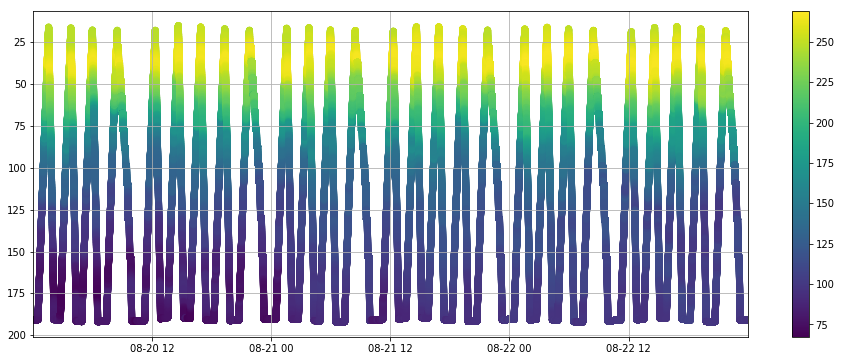

In [40]:
### First, a simple colored "curtain" time series, with oxygen as the parameter of interest
### note: this plot isn't particularly interesting at this scale, as there is lots of whitespace between profiles
x = ds['time'].values
y = ds['seawater_pressure'].values
z = ds['corrected_dissolved_oxygen'].values
fig, ax = plt.subplots()
fig.set_size_inches(16, 6);
ax.invert_yaxis()
ax.grid()
ax.set_xlim(x[0],x[-1])
sc = plt.scatter(x, y, c=z)
cb = fig.colorbar(sc, ax=ax)
cb.update_ticks()
cb.formatter.set_useOffset(False)
plt.show()

In [ ]:
## Next, a T-S plot over the same time period, using time for the color
x2 = ds['time'].values
y2 = ds['seawater_temperature'].values
z2 = ds['practical_salinity'].values
fig2, ax2 = plt.subplots()
fig2.set_size_inches(16, 6);
ax2.invert_yaxis()
ax2.grid()
#ax.set_xlim(x[0],x[-1])
sc = plt.scatter(y2, z2,c=x2)
plt.title('Temperature vs. Salinity')
cb = fig2.colorbar(sc, ax=ax2)
cb.update_ticks()
cb.formatter.set_useOffset(False)
plt.show()

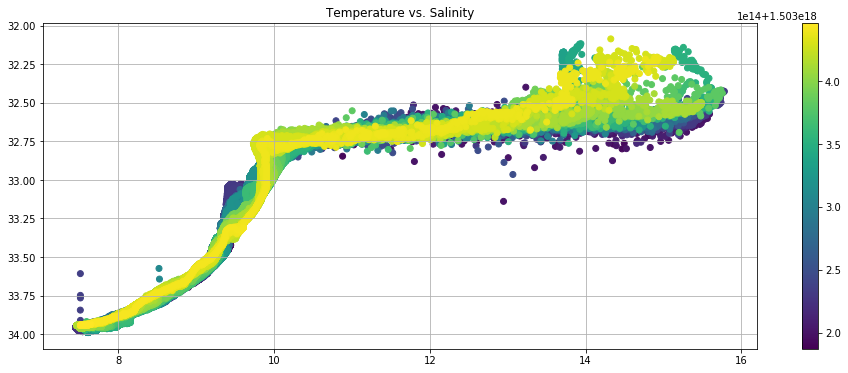

This makes me wonder what the curtain plot looks like for just temperature, as the excursions in the upper right seem a little weird (mixing? cooling? Better ask a physical oceanographer!)


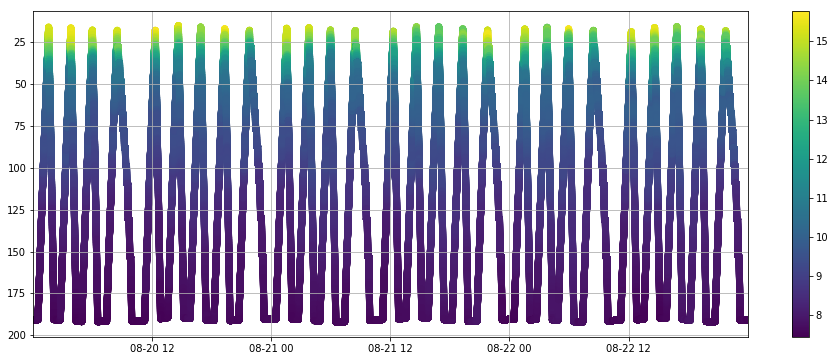

In [43]:
### First, a simple colored "curtain" time series, with oxygen as the parameter of interest
### note: this plot isn't particularly interesting at this scale, as there is lots of whitespace between profiles
fig3, ax3 = plt.subplots()
fig3.set_size_inches(16, 6);
ax3.invert_yaxis()
ax3.grid()
ax3.set_xlim(x[0],x[-1])
sc = plt.scatter(x, y, c=y2)
cb = fig.colorbar(sc, ax=ax3)
cb.update_ticks()
cb.formatter.set_useOffset(False)
plt.show()

How about plotting up spectral irradiance?

In [98]:
## parameters for the node and sensore we are working with
subsite = 'RS01SBPS'
node = 'SF01A'
sensor = '3D-SPKIRA101'        # this is the sensor designator. Copied from http://ooi.visualocean.net/sites/view/RS01SBPS
method = 'streamed'
stream = 'spkir_data_record'     # this is the stream (found id by clicking in to the sensor from page above)

## set time slice we are interested in to be the period of the eclipse
beginDT = '2017-08-20T00:00:00.000Z'
endDT = '2017-08-23T00:00:00.000Z'


In [99]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))

params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}

# note: there is a "session" approach here as well instead of the raw request that can help if the server gets 
# bogged down# TODO: get details from Fredreich on that

r = requests.get(data_request_url, params=params, auth=(username, token))
specIR_data = r.json()
specIR_data

{'allURLs': ['https://opendap.oceanobservatories.org/thredds/catalog/ooi/cbps@uw.edu/20180223T094118-RS01SBPS-SF01A-3D-SPKIRA101-streamed-spkir_data_record/catalog.html',
  'https://opendap.oceanobservatories.org/async_results/cbps@uw.edu/20180223T094118-RS01SBPS-SF01A-3D-SPKIRA101-streamed-spkir_data_record'],
 'numberOfSubJobs': 13,
 'outputURL': 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/cbps@uw.edu/20180223T094118-RS01SBPS-SF01A-3D-SPKIRA101-streamed-spkir_data_record/catalog.html',
 'requestUUID': 'd7b2968c-833b-4e13-abde-2b52ce1a9a42',
 'sizeCalculation': 100550893,
 'timeCalculation': 412}

In [100]:
%%time
check_complete = specIR_data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 1.43 s, sys: 48 ms, total: 1.48 s
Wall time: 1min


In [101]:
url = specIR_data['allURLs'][0]
# url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/friedrich.knuth@rutgers.edu/20180221T052204-RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
par_datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', par_datasets)
x = re.findall(r'(ooi/.*?.nc)', par_datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
specIR_datasets = [os.path.join(tds_url, i) for i in x]

In [97]:
specIR_datasets


['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/cbps@uw.edu/20180223T091936-RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample/deployment0004_RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample_20170820T000000.142867-20170822T235959.732682.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/cbps@uw.edu/20180223T091936-RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample/deployment0004_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20170820T000000.731864-20170822T235959.926493.nc']

In [115]:
# for some reason this code doesn't work for the specIR data, so I just downloaded the nc directly and
# will load from the data directory

specIR_ds = xr.open_dataset('data/deployment0004_RS01SBPS-SF01A-3D-SPKIRA101-streamed-spkir_data_record_20170820T000000.154282-20170822T235959.992811.nc')

In [116]:
#specIR_ds = xr.open_dataset('https://opendap.oceanobservatories.org/thredds/dodsC/ooi/cbps@uw.edu/20180223T091936-RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample/deployment0004_RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample_20170820T000000.142867-20170822T235959.732682.nc')

In [106]:
!pwd
#par_ds = xr.open_mfdataset(par_datasets)
#par_ds = par_ds.swap_dims({'obs': 'time'})

/home/jovyan/cahw2018_shallow_profiler_access/visualization/cpsarason_dev


In [117]:
specIR_ds = specIR_ds.swap_dims({'obs':'time'})

In [118]:
specIR_ds

<xarray.Dataset>
Dimensions:                   (spectra: 7, time: 1032513)
Coordinates:
    obs                       (time) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
  * time                      (time) datetime64[ns] 2017-08-20T00:00:00.154281984 ...
    lat                       (time) float64 ...
    lon                       (time) float64 ...
Dimensions without coordinates: spectra
Data variables:
    deployment                (time) int32 ...
    id                        (time) |S36 ...
    checksum                  (time) float64 ...
    driver_timestamp          (time) datetime64[ns] ...
    frame_counter             (time) float64 ...
    ingestion_timestamp       (time) datetime64[ns] ...
    instrument_id             (time) object ...
    internal_temperature      (time) float64 ...
    internal_timestamp        (time) datetime64[ns] ...
    port_timestamp            (time) datetime64[ns] ...
    preferred_timestamp       (time) object ...
    provenance                (ti

/opt/conda/lib/python3.6/site-packages/IPython/core/oinspect.py:797: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  out['length'] = str(len(obj))


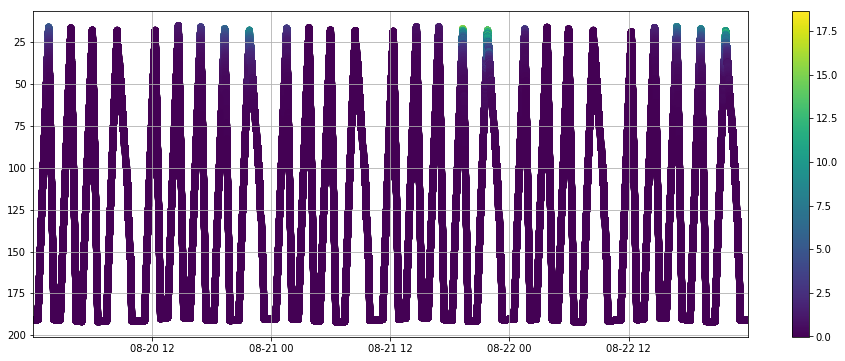

In [123]:
### First, a simple colored "curtain" time series, with oxygen as the parameter of interest
### note: this plot isn't particularly interesting at this scale, as there is lots of whitespace between profiles
x4 = specIR_ds['time'].values
y4 = specIR_ds['seawater_pressure'].values
z4 = specIR_ds['spkir_downwelling_vector'][:,1].values
fig4, ax4 = plt.subplots()
fig4.set_size_inches(16, 6);
ax4.invert_yaxis()
ax4.grid()
ax4.set_xlim(x4[0],x4[-1])
sc4 = plt.scatter(x4, y4, c=z4)
cb4 = fig4.colorbar(sc4, ax=ax4)
cb4.update_ticks()
cb4.formatter.set_useOffset(False)
plt.show()

In [130]:
specIR_ds['spkir_downwelling_vector'].comments

AttributeError: 'DataArray' object has no attribute 'comments'